# Data Extraction

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import numpy as np
from wordcloud import WordCloud

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 100
page_size = 100

reviews_data = []

for i in range(1, pages + 1): 

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Extracting reviews
    reviews = parsed_content.select('article[class*="comp_media-review-rated"]')

    # Extracting review details
    for review in reviews:
        review_data = {}

        # Extract the date tag
        date_tag = review.find("time", itemprop="datePublished")
        if date_tag:
            review_data['dates'] = date_tag.text.strip()

        # Extracting customer names
        customer_name_tag = review.find("span", itemprop="name")
        if customer_name_tag:
            review_data['customer_names'] = customer_name_tag.text.strip()

        # Extracting country
        country = review.find(text=lambda text: text and '(' in text and ')' in text)
        if country:
            country = country.strip('()')
        else:
            country = None

        review_data['countries'] = country

        # Extracting review bodies
        review_body = review.find("div", itemprop="reviewBody")
        if review_body:
            review_data['review_bodies'] = review_body.text.strip()

        # Extracting review ratings
        review_ratings = review.find('table', class_='review-ratings')
        if review_ratings:
            rows = review_ratings.find_all('tr')
            for row in rows:
                header = row.find('td', class_='review-rating-header')
                if header:
                    header_text = header.text.strip()
                    if header_text in ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']:
                        stars_td = row.find('td', class_='review-rating-stars')
                        if stars_td:
                            stars = stars_td.find_all('span', class_='star fill')
                            review_data[header_text] = len(stars)
                    else:
                        value = row.find('td', class_='review-value')
                        if value:
                            review_data[header_text] = value.text.strip()

        # Append the review data dictionary to the reviews_data list
        reviews_data.append(review_data)

print("Reviews Data:")
for review_data in reviews_data:
    print(review_data)


Scraping page 1


C:\Users\m.pham\AppData\Local\Temp\ipykernel_16896\484766976.py:39: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  country = review.find(text=lambda text: text and '(' in text and ')' in text)


Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
Scraping page 16
Scraping page 17
Scraping page 18
Scraping page 19
Scraping page 20
Scraping page 21
Scraping page 22
Scraping page 23
Scraping page 24
Scraping page 25
Scraping page 26
Scraping page 27
Scraping page 28
Scraping page 29
Scraping page 30
Scraping page 31
Scraping page 32
Scraping page 33
Scraping page 34
Scraping page 35
Scraping page 36
Scraping page 37
Scraping page 38
Scraping page 39
Scraping page 40
Scraping page 41
Scraping page 42
Scraping page 43
Scraping page 44
Scraping page 45
Scraping page 46
Scraping page 47
Scraping page 48
Scraping page 49
Scraping page 50
Scraping page 51
Scraping page 52
Scraping page 53
Scraping page 54
Scraping page 55
Scraping page 56
Scraping page 57
Scraping page 58
Scraping page 59
Scraping page 60
Scrap

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
import pandas as pd
df = pd.DataFrame(reviews_data) 
df.head()

,dates,customer_names,countries,review_bodies,Type Of Traveller,Seat Type,Route,Date Flown,Value For Money,Recommended,Aircraft,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity
0,23rd February 2024,Peter Hansell,(United Kingdom),✅ Trip Verified | That was supposed to be my ...,Couple Leisure,Economy Class,Pisa to London Heathrow,September 2023,1,no,NaN,NaN,NaN,NaN,NaN,NaN
1,21st February 2024,Caleb Lowe,(United Kingdom),✅ Trip Verified | Have no fear when your BA f...,Couple Leisure,Business Class,Malaga to London Heathrow,February 2024,4,yes,A320,5.0,5.0,5.0,4.0,NaN
2,17th February 2024,Kevin Statham,(United States),Not Verified | We have flown BA five times fr...,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February 2024,1,no,A350,1.0,5.0,3.0,1.0,1.0
3,17th February 2024,C Horton,(United Kingdom),✅ Trip Verified | London Heathrow to Istanbul...,Solo Leisure,Economy Class,London to Istanbul,February 2024,2,no,A320,3.0,1.0,1.0,2.0,NaN
4,16th February 2024,Anthony C Gallagher,(United States),"Not Verified | Jan 30th, I booked a last-minut...",Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January 2024,2,no,Boeing 777,3.0,5.0,3.0,4.0,NaN


# Data Cleaning

## Formatting

### Cleaning Country Column

In [4]:
# Remove parentheses from the countries column
df['countries'] = df['countries'].str.replace('(', '').str.replace(')', '')
df.head()

,dates,customer_names,countries,review_bodies,Type Of Traveller,Seat Type,Route,Date Flown,Value For Money,Recommended,Aircraft,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity
0,23rd February 2024,Peter Hansell,United Kingdom,✅ Trip Verified | That was supposed to be my ...,Couple Leisure,Economy Class,Pisa to London Heathrow,September 2023,1,no,NaN,NaN,NaN,NaN,NaN,NaN
1,21st February 2024,Caleb Lowe,United Kingdom,✅ Trip Verified | Have no fear when your BA f...,Couple Leisure,Business Class,Malaga to London Heathrow,February 2024,4,yes,A320,5.0,5.0,5.0,4.0,NaN
2,17th February 2024,Kevin Statham,United States,Not Verified | We have flown BA five times fr...,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February 2024,1,no,A350,1.0,5.0,3.0,1.0,1.0
3,17th February 2024,C Horton,United Kingdom,✅ Trip Verified | London Heathrow to Istanbul...,Solo Leisure,Economy Class,London to Istanbul,February 2024,2,no,A320,3.0,1.0,1.0,2.0,NaN
4,16th February 2024,Anthony C Gallagher,United States,"Not Verified | Jan 30th, I booked a last-minut...",Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January 2024,2,no,Boeing 777,3.0,5.0,3.0,4.0,NaN


### Cleaning Review Bodies

In [5]:
# Clean Review Bodies into Bodies and Verified

# Split the review_bodies column into two separate columns
split_df = df['review_bodies'].str.split('|', expand=True)

# If the split results in only one column, assign the first column to 'review' and set 'verified' to None
if len(split_df.columns) == 1:
    split_df.columns = ['review']
    split_df['verified'] = None
else:
    split_df.columns = ['verified', 'review']

# Assign the split columns to the DataFrame
df[['verified', 'review']] = split_df

# Check if the review column is None and the verified column is not None
mask = (df['review'].isnull()) & (df['verified'].notnull())

# Swap values between review and verified columns where the condition is met
df.loc[mask, ['review', 'verified']] = df.loc[mask, ['verified', 'review']].values

# Assuming df is your DataFrame
df.drop(columns=['review_bodies'], inplace=True)

# Check if 'verified' column contains 'Trip Verified' and replace with True, else replace with False
df['verified'] = df['verified'].str.contains('Trip Verified', case=False, na=False)
df.head()


,dates,customer_names,countries,Type Of Traveller,Seat Type,Route,Date Flown,Value For Money,Recommended,Aircraft,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity,verified,review
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September 2023,1,no,NaN,NaN,NaN,NaN,NaN,NaN,True,That was supposed to be my flight but it was...
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February 2024,4,yes,A320,5.0,5.0,5.0,4.0,NaN,True,Have no fear when your BA flight is operated...
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February 2024,1,no,A350,1.0,5.0,3.0,1.0,1.0,False,We have flown BA five times from western USA...
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February 2024,2,no,A320,3.0,1.0,1.0,2.0,NaN,True,London Heathrow to Istanbul at the start of ...
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January 2024,2,no,Boeing 777,3.0,5.0,3.0,4.0,NaN,False,"Jan 30th, I booked a last-minute, transatlant..."


### Cleaning Dates Review

In [6]:
# Split the 'dates' column into separate columns for day, month, and year
df[['Day Review', 'Month Review', 'Year Review']] = df['dates'].str.split(expand=True)

# Remove the last 2 characters from the 'Day Review' column
df['Day Review'] = df['Day Review'].str[:-2]

# Concatenate 'Day Review', 'Month Review', and 'Year Review' into a single string
date_strings = df['Day Review'] + ' ' + df['Month Review'] + ' ' + df['Year Review']

# Create the 'Dates' column by converting the concatenated strings to datetime objects
df['Dates Review'] = pd.to_datetime(date_strings, format='%d %B %Y')

df.head()

,dates,customer_names,countries,Type Of Traveller,Seat Type,Route,Date Flown,Value For Money,Recommended,Aircraft,...,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity,verified,review,Day Review,Month Review,Year Review,Dates Review
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September 2023,1,no,NaN,...,NaN,NaN,NaN,NaN,True,That was supposed to be my flight but it was...,23,February,2024,2024-02-23
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February 2024,4,yes,A320,...,5.0,5.0,4.0,NaN,True,Have no fear when your BA flight is operated...,21,February,2024,2024-02-21
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February 2024,1,no,A350,...,5.0,3.0,1.0,1.0,False,We have flown BA five times from western USA...,17,February,2024,2024-02-17
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February 2024,2,no,A320,...,1.0,1.0,2.0,NaN,True,London Heathrow to Istanbul at the start of ...,17,February,2024,2024-02-17
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January 2024,2,no,Boeing 777,...,5.0,3.0,4.0,NaN,False,"Jan 30th, I booked a last-minute, transatlant...",16,February,2024,2024-02-16


### Cleaning Month Flown

In [7]:
# rename date flown to month flown
df.rename(columns={'Date Flown': 'Month Flown'}, inplace=True)
df.head()

,dates,customer_names,countries,Type Of Traveller,Seat Type,Route,Month Flown,Value For Money,Recommended,Aircraft,...,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity,verified,review,Day Review,Month Review,Year Review,Dates Review
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September 2023,1,no,NaN,...,NaN,NaN,NaN,NaN,True,That was supposed to be my flight but it was...,23,February,2024,2024-02-23
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February 2024,4,yes,A320,...,5.0,5.0,4.0,NaN,True,Have no fear when your BA flight is operated...,21,February,2024,2024-02-21
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February 2024,1,no,A350,...,5.0,3.0,1.0,1.0,False,We have flown BA five times from western USA...,17,February,2024,2024-02-17
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February 2024,2,no,A320,...,1.0,1.0,2.0,NaN,True,London Heathrow to Istanbul at the start of ...,17,February,2024,2024-02-17
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January 2024,2,no,Boeing 777,...,5.0,3.0,4.0,NaN,False,"Jan 30th, I booked a last-minute, transatlant...",16,February,2024,2024-02-16


In [8]:
# Split Month Flown to Month Flown and Year Flown
df[['Month Flown', 'Year Flown']] = df['Month Flown'].str.split(' ', expand=True)
df.head()

,dates,customer_names,countries,Type Of Traveller,Seat Type,Route,Month Flown,Value For Money,Recommended,Aircraft,...,Food & Beverages,Ground Service,Wifi & Connectivity,verified,review,Day Review,Month Review,Year Review,Dates Review,Year Flown
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September,1,no,NaN,...,NaN,NaN,NaN,True,That was supposed to be my flight but it was...,23,February,2024,2024-02-23,2023
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February,4,yes,A320,...,5.0,4.0,NaN,True,Have no fear when your BA flight is operated...,21,February,2024,2024-02-21,2024
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February,1,no,A350,...,3.0,1.0,1.0,False,We have flown BA five times from western USA...,17,February,2024,2024-02-17,2024
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February,2,no,A320,...,1.0,2.0,NaN,True,London Heathrow to Istanbul at the start of ...,17,February,2024,2024-02-17,2024
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January,2,no,Boeing 777,...,3.0,4.0,NaN,False,"Jan 30th, I booked a last-minute, transatlant...",16,February,2024,2024-02-16,2024


In [9]:
# Define a dictionary mapping month names to numerical values
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Map the month names to their corresponding numerical values and create the "Month Flown Number" column
df['Month Flown Number'] = df['Month Flown'].map(month_mapping)
df['Month Review Number'] = df['Month Review'].map(month_mapping)
df.head()

,dates,customer_names,countries,Type Of Traveller,Seat Type,Route,Month Flown,Value For Money,Recommended,Aircraft,...,Wifi & Connectivity,verified,review,Day Review,Month Review,Year Review,Dates Review,Year Flown,Month Flown Number,Month Review Number
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September,1,no,NaN,...,NaN,True,That was supposed to be my flight but it was...,23,February,2024,2024-02-23,2023,9.0,2
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February,4,yes,A320,...,NaN,True,Have no fear when your BA flight is operated...,21,February,2024,2024-02-21,2024,2.0,2
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February,1,no,A350,...,1.0,False,We have flown BA five times from western USA...,17,February,2024,2024-02-17,2024,2.0,2
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February,2,no,A320,...,NaN,True,London Heathrow to Istanbul at the start of ...,17,February,2024,2024-02-17,2024,2.0,2
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January,2,no,Boeing 777,...,NaN,False,"Jan 30th, I booked a last-minute, transatlant...",16,February,2024,2024-02-16,2024,1.0,2


In [10]:
# Convert 'Month Flown Number' to string and pad with zero if necessary
df['Month Flown Number'] = df['Month Flown Number'].replace(['NA', 'inf'], np.nan)  # Replace 'NA' and 'inf' with NaN
df['Month Flown Number'] = df['Month Flown Number'].astype(float).astype(pd.Int64Dtype())  # Convert to float and then to integer

# Combine 'Month Flown Number' and 'Year Flown' into a single string
df['Month Year Flown'] = df['Year Flown'].astype(str) + '-' + df['Month Flown Number'].astype(str).str.zfill(2) + '-' + '01'

# Convert the combined string to datetime, handling NaN values gracefully
df['Month Year Flown'] = pd.to_datetime(df['Month Year Flown'], errors='coerce')

# Format 'Month Year Flown' column to display 'MM/YYYY' format
df['Month Year Flown'] = df['Month Year Flown'].dt.strftime('%m/%Y')

### Rename Columns

In [11]:
# Rename columns
df = df.rename(columns={
    'verified': 'Verified',
    'review': 'Review',
    'customer_names': 'Customer Name',
    'countries': 'Country'
})


In [12]:
# Convert 'Yes' to 1 and 'No' to 0 in the 'recommended' column
df['Recommended'] = df['Recommended'].replace({'yes': 1, 'no': 0})
df.head()

,dates,Customer Name,Country,Type Of Traveller,Seat Type,Route,Month Flown,Value For Money,Recommended,Aircraft,...,Verified,Review,Day Review,Month Review,Year Review,Dates Review,Year Flown,Month Flown Number,Month Review Number,Month Year Flown
0,23rd February 2024,Peter Hansell,United Kingdom,Couple Leisure,Economy Class,Pisa to London Heathrow,September,1,0,NaN,...,True,That was supposed to be my flight but it was...,23,February,2024,2024-02-23,2023,9,2,09/2023
1,21st February 2024,Caleb Lowe,United Kingdom,Couple Leisure,Business Class,Malaga to London Heathrow,February,4,1,A320,...,True,Have no fear when your BA flight is operated...,21,February,2024,2024-02-21,2024,2,2,02/2024
2,17th February 2024,Kevin Statham,United States,Couple Leisure,Economy Class,Phoenix to Lisbon via London,February,1,0,A350,...,False,We have flown BA five times from western USA...,17,February,2024,2024-02-17,2024,2,2,02/2024
3,17th February 2024,C Horton,United Kingdom,Solo Leisure,Economy Class,London to Istanbul,February,2,0,A320,...,True,London Heathrow to Istanbul at the start of ...,17,February,2024,2024-02-17,2024,2,2,02/2024
4,16th February 2024,Anthony C Gallagher,United States,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",January,2,0,Boeing 777,...,False,"Jan 30th, I booked a last-minute, transatlant...",16,February,2024,2024-02-16,2024,1,2,01/2024


In [13]:
# Reorder Columns
df =df[['Dates Review', 'Day Review', 'Month Review','Month Review Number','Year Review','Verified','Review','Customer Name',
    'Month Flown','Month Flown Number', 'Year Flown', 'Month Year Flown','Country', 'Aircraft', 'Type Of Traveller',
    'Seat Type', 'Route','Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Ground Service',
    'Value For Money', 'Wifi & Connectivity','Recommended' ]]
df.head()

,Dates Review,Day Review,Month Review,Month Review Number,Year Review,Verified,Review,Customer Name,Month Flown,Month Flown Number,...,Type Of Traveller,Seat Type,Route,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,2024-02-23,23,February,2,2024,True,That was supposed to be my flight but it was...,Peter Hansell,September,9,...,Couple Leisure,Economy Class,Pisa to London Heathrow,NaN,NaN,NaN,NaN,1,NaN,0
1,2024-02-21,21,February,2,2024,True,Have no fear when your BA flight is operated...,Caleb Lowe,February,2,...,Couple Leisure,Business Class,Malaga to London Heathrow,5.0,5.0,5.0,4.0,4,NaN,1
2,2024-02-17,17,February,2,2024,False,We have flown BA five times from western USA...,Kevin Statham,February,2,...,Couple Leisure,Economy Class,Phoenix to Lisbon via London,1.0,5.0,3.0,1.0,1,1.0,0
3,2024-02-17,17,February,2,2024,True,London Heathrow to Istanbul at the start of ...,C Horton,February,2,...,Solo Leisure,Economy Class,London to Istanbul,3.0,1.0,1.0,2.0,2,NaN,0
4,2024-02-16,16,February,2,2024,False,"Jan 30th, I booked a last-minute, transatlant...",Anthony C Gallagher,January,1,...,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",3.0,5.0,3.0,4.0,2,NaN,0


In [14]:
# Check the data types
df.dtypes

Dates Review           datetime64[ns]
Day Review                     object
Month Review                   object
Month Review Number             int64
Year Review                    object
Verified                         bool
Review                         object
Customer Name                  object
Month Flown                    object
Month Flown Number              Int64
Year Flown                     object
Month Year Flown               object
Country                        object
Aircraft                       object
Type Of Traveller              object
Seat Type                      object
Route                          object
Seat Comfort                  float64
Cabin Staff Service           float64
Food & Beverages              float64
Ground Service                float64
Value For Money                 int64
Wifi & Connectivity           float64
Recommended                     int64
dtype: object

In [15]:
# Export the DataFrame to a CSV file for business purposes
df.to_csv('British_Airline.csv', index=False)

## Null handling

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3754 entries, 0 to 3753
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Dates Review         3754 non-null   datetime64[ns]
 1   Day Review           3754 non-null   object        
 2   Month Review         3754 non-null   object        
 3   Month Review Number  3754 non-null   int64         
 4   Year Review          3754 non-null   object        
 5   Verified             3754 non-null   bool          
 6   Review               3754 non-null   object        
 7   Customer Name        3754 non-null   object        
 8   Month Flown          2976 non-null   object        
 9   Month Flown Number   2976 non-null   Int64         
 10  Year Flown           2976 non-null   object        
 11  Month Year Flown     2976 non-null   object        
 12  Country              3752 non-null   object        
 13  Aircraft             1952 non-nul

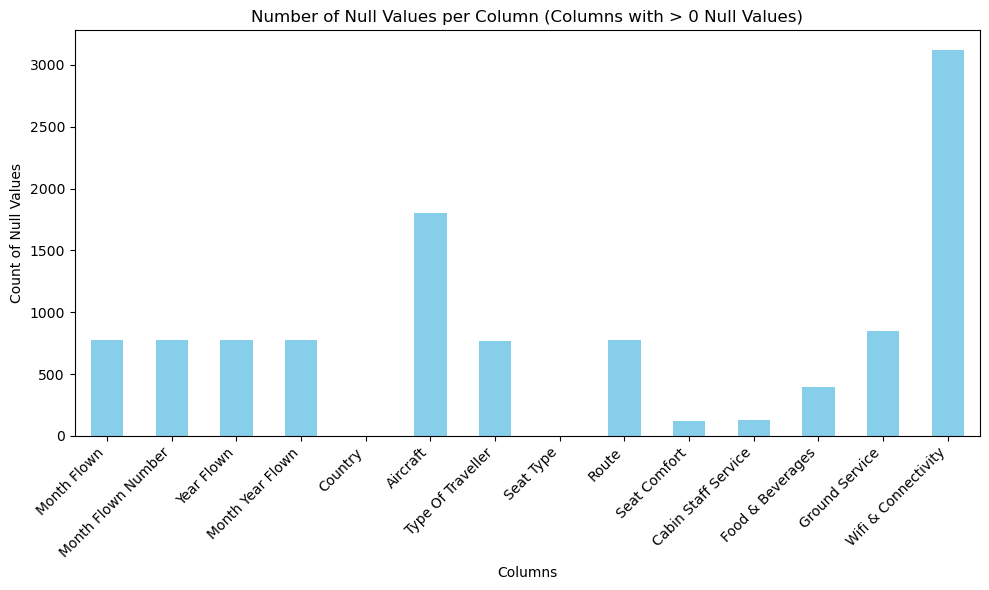

In [17]:
# Count number of null values per column
null_counts = df.isnull().sum()

# Filter columns with more than 0 null values
filtered_null_counts = null_counts[null_counts > 0]

# Plot
plt.figure(figsize=(10, 6))
filtered_null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Null Values per Column (Columns with > 0 Null Values)')
plt.xlabel('Columns')
plt.ylabel('Count of Null Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Cleaning Review Column

In [48]:
# Trim leading spaces in the 'Review' column
df['Review'] = df['Review'].str.strip()

## ID column

In [18]:
# Reset index to create ID column starting from 0
df.reset_index(drop=True, inplace=True)

In [19]:
df.head()

,Dates Review,Day Review,Month Review,Month Review Number,Year Review,Verified,Review,Customer Name,Month Flown,Month Flown Number,...,Type Of Traveller,Seat Type,Route,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,2024-02-23,23,February,2,2024,True,That was supposed to be my flight but it was...,Peter Hansell,September,9,...,Couple Leisure,Economy Class,Pisa to London Heathrow,NaN,NaN,NaN,NaN,1,NaN,0
1,2024-02-21,21,February,2,2024,True,Have no fear when your BA flight is operated...,Caleb Lowe,February,2,...,Couple Leisure,Business Class,Malaga to London Heathrow,5.0,5.0,5.0,4.0,4,NaN,1
2,2024-02-17,17,February,2,2024,False,We have flown BA five times from western USA...,Kevin Statham,February,2,...,Couple Leisure,Economy Class,Phoenix to Lisbon via London,1.0,5.0,3.0,1.0,1,1.0,0
3,2024-02-17,17,February,2,2024,True,London Heathrow to Istanbul at the start of ...,C Horton,February,2,...,Solo Leisure,Economy Class,London to Istanbul,3.0,1.0,1.0,2.0,2,NaN,0
4,2024-02-16,16,February,2,2024,False,"Jan 30th, I booked a last-minute, transatlant...",Anthony C Gallagher,January,1,...,Solo Leisure,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",3.0,5.0,3.0,4.0,2,NaN,0


# EDA (Exploratory Data Analysis) Diagnostic and Diagnostic Analysis

## Services Analysis

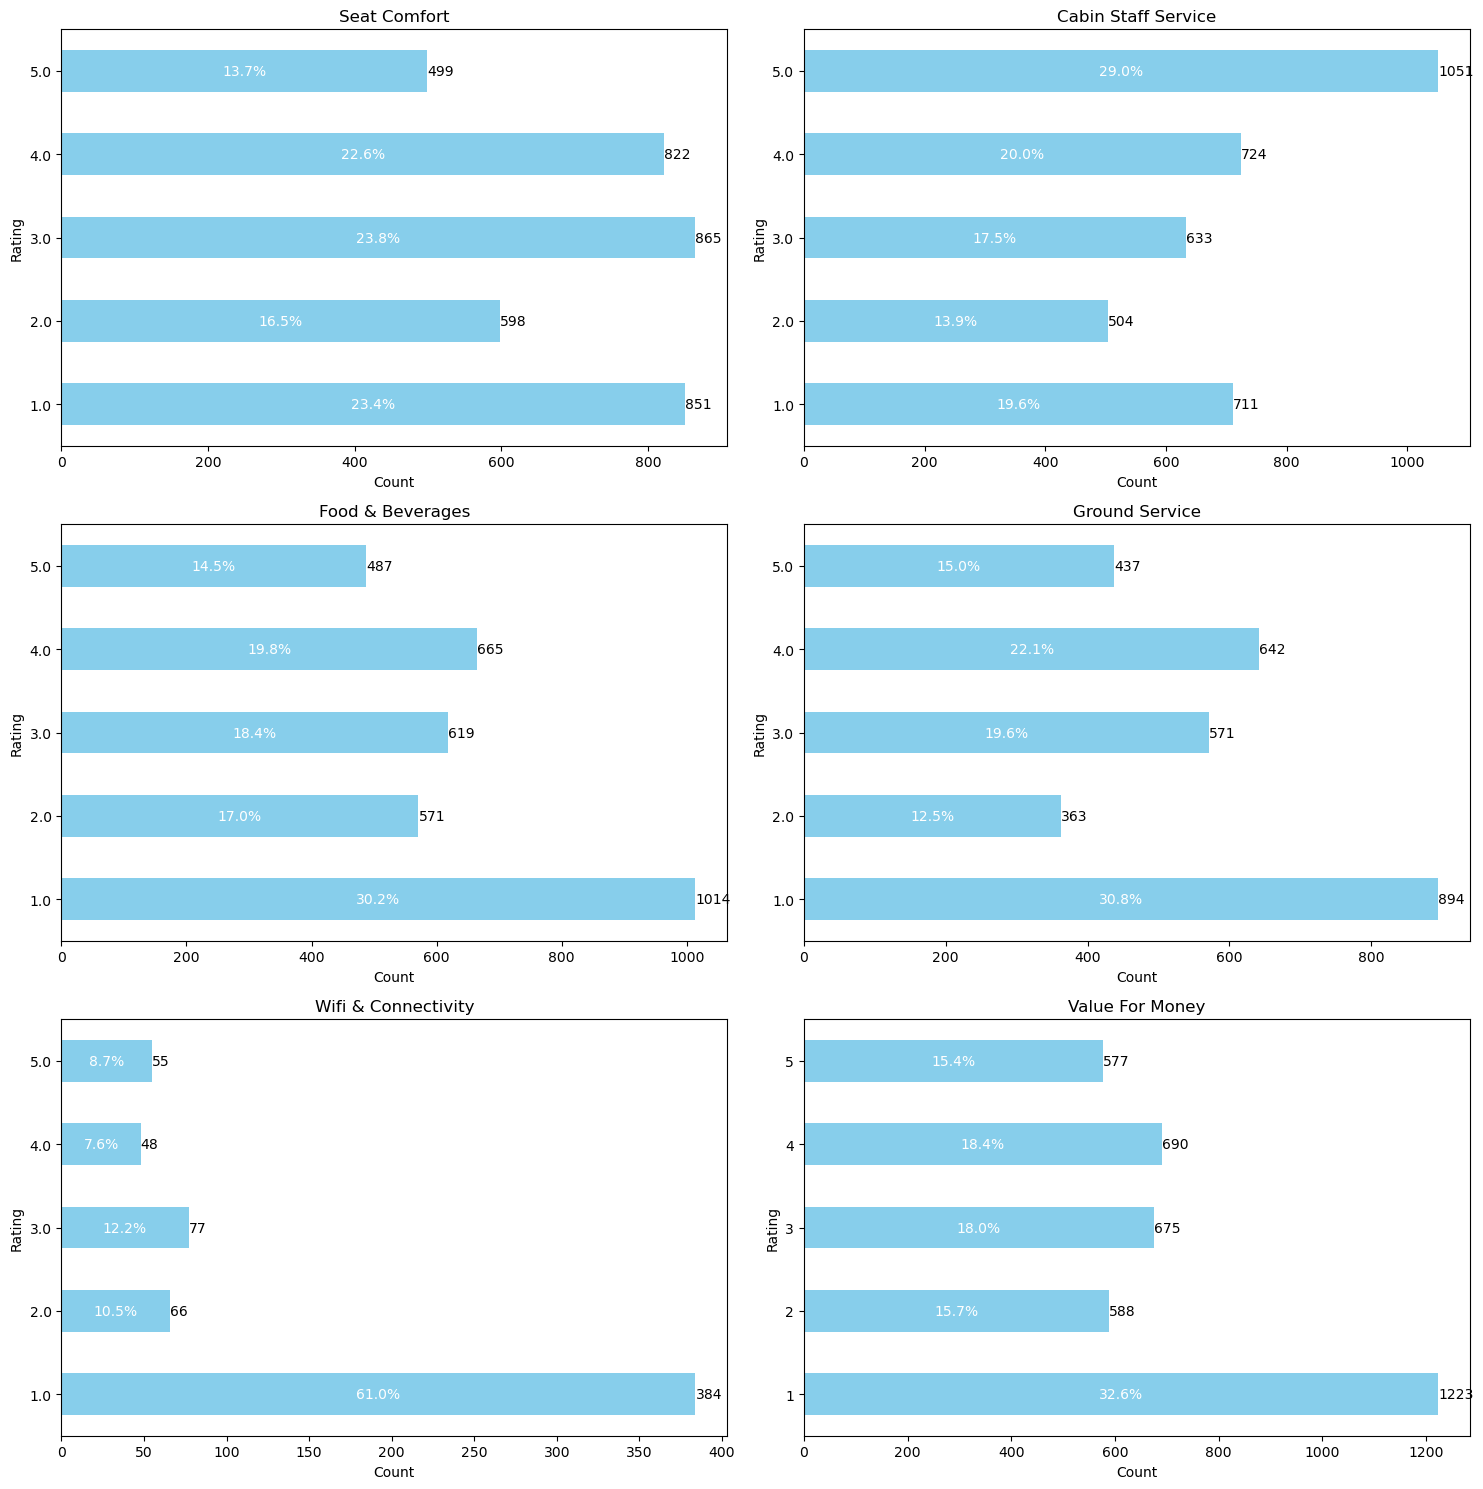

In [20]:
# Define the list of columns
columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate over each column and plot
for i, column in enumerate(columns):
    # Exclude 0 values for 'Food & Beverages' and 'Value For Money' columns
    if column in ['Food & Beverages', 'Value For Money']:
        filtered_data = df[df[column] != 0]
        counts = filtered_data[column].value_counts().sort_index()
    else:
        counts = df[column].value_counts().sort_index()
    
    # Plot the data horizontally
    counts.plot(kind='barh', ax=axes[i], color='skyblue')
    
    # Add titles and labels
    axes[i].set_title(column)
    axes[i].set_ylabel('Rating')
    axes[i].set_xlabel('Count')
    
    # Calculate percentage of total
    total_count = counts.sum()
    for j, (index, value) in enumerate(counts.items()):
        # Add percentage at the middle of the bar
        percentage = '{:.1f}%'.format(100 * value / total_count)
        axes[i].text(value / 2, j, percentage, ha='center', va='center', color='white')
        
        # Add total count at the right of the bar
        axes[i].text(value, j, str(value), ha='left', va='center', color='black')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [52]:
# Define the list of columns
columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']

# Create a dictionary to store summary statistics for each column
summary_statistics = {}

# Compute summary statistics for each column
for column in columns:
    # Compute summary statistics for the current column
    summary_statistics[column] = df[column].describe()

# Create a DataFrame to store the summary statistics
summary_df = pd.DataFrame(summary_statistics)
summary_df


,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity,Value For Money
count,3635.000000,3623.000000,3357.000000,2907.000000,630.000000,3754.000000
mean,2.867950,3.248413,2.713137,2.781562,1.926984,2.682206
std,1.363553,1.491040,1.441422,1.459512,1.348992,1.469820
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000
75%,4.000000,5.000000,4.000000,4.000000,3.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


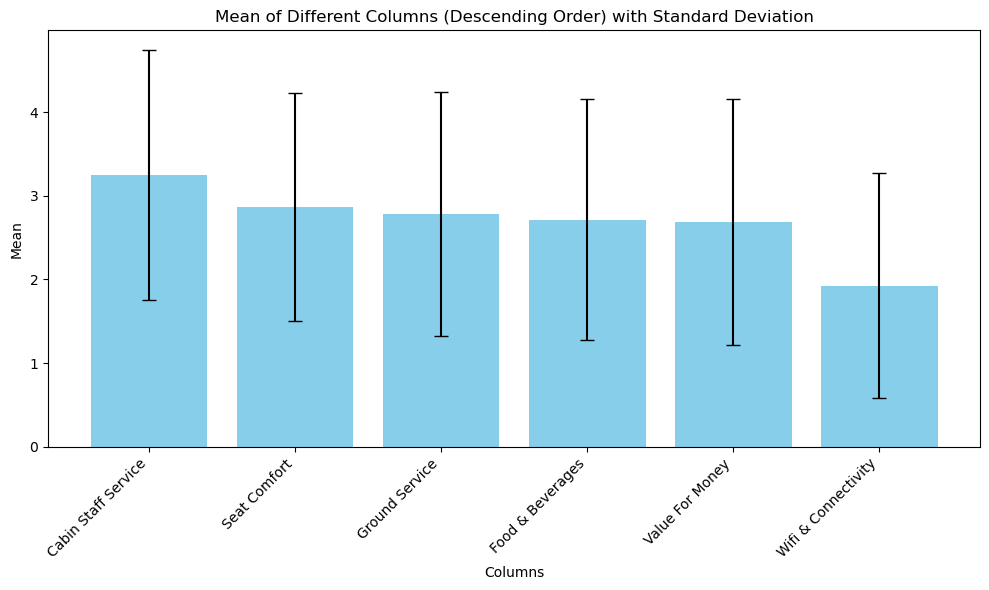

In [22]:
columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']

# Create a dictionary to store summary statistics for each column
summary_statistics = {}

# Compute summary statistics for each column
for column in columns:
    # Compute summary statistics for the current column
    summary_statistics[column] = df[column].describe()

# Extract the mean values and standard deviations for each column
means = [summary_statistics[column]['mean'] for column in columns]
stds = [summary_statistics[column]['std'] for column in columns]

# Sort the means and columns in descending order
sorted_means, sorted_columns = zip(*sorted(zip(means, columns), reverse=True))
sorted_stds = [summary_statistics[column]['std'] for column in sorted_columns]

# Plot the means of each column in descending order with error bars
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns, sorted_means, color='skyblue', yerr=sorted_stds, capsize=5)  # Add error bars with std
plt.xlabel('Columns')
plt.ylabel('Mean')
plt.title('Mean of Different Columns (Descending Order) with Standard Deviation')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

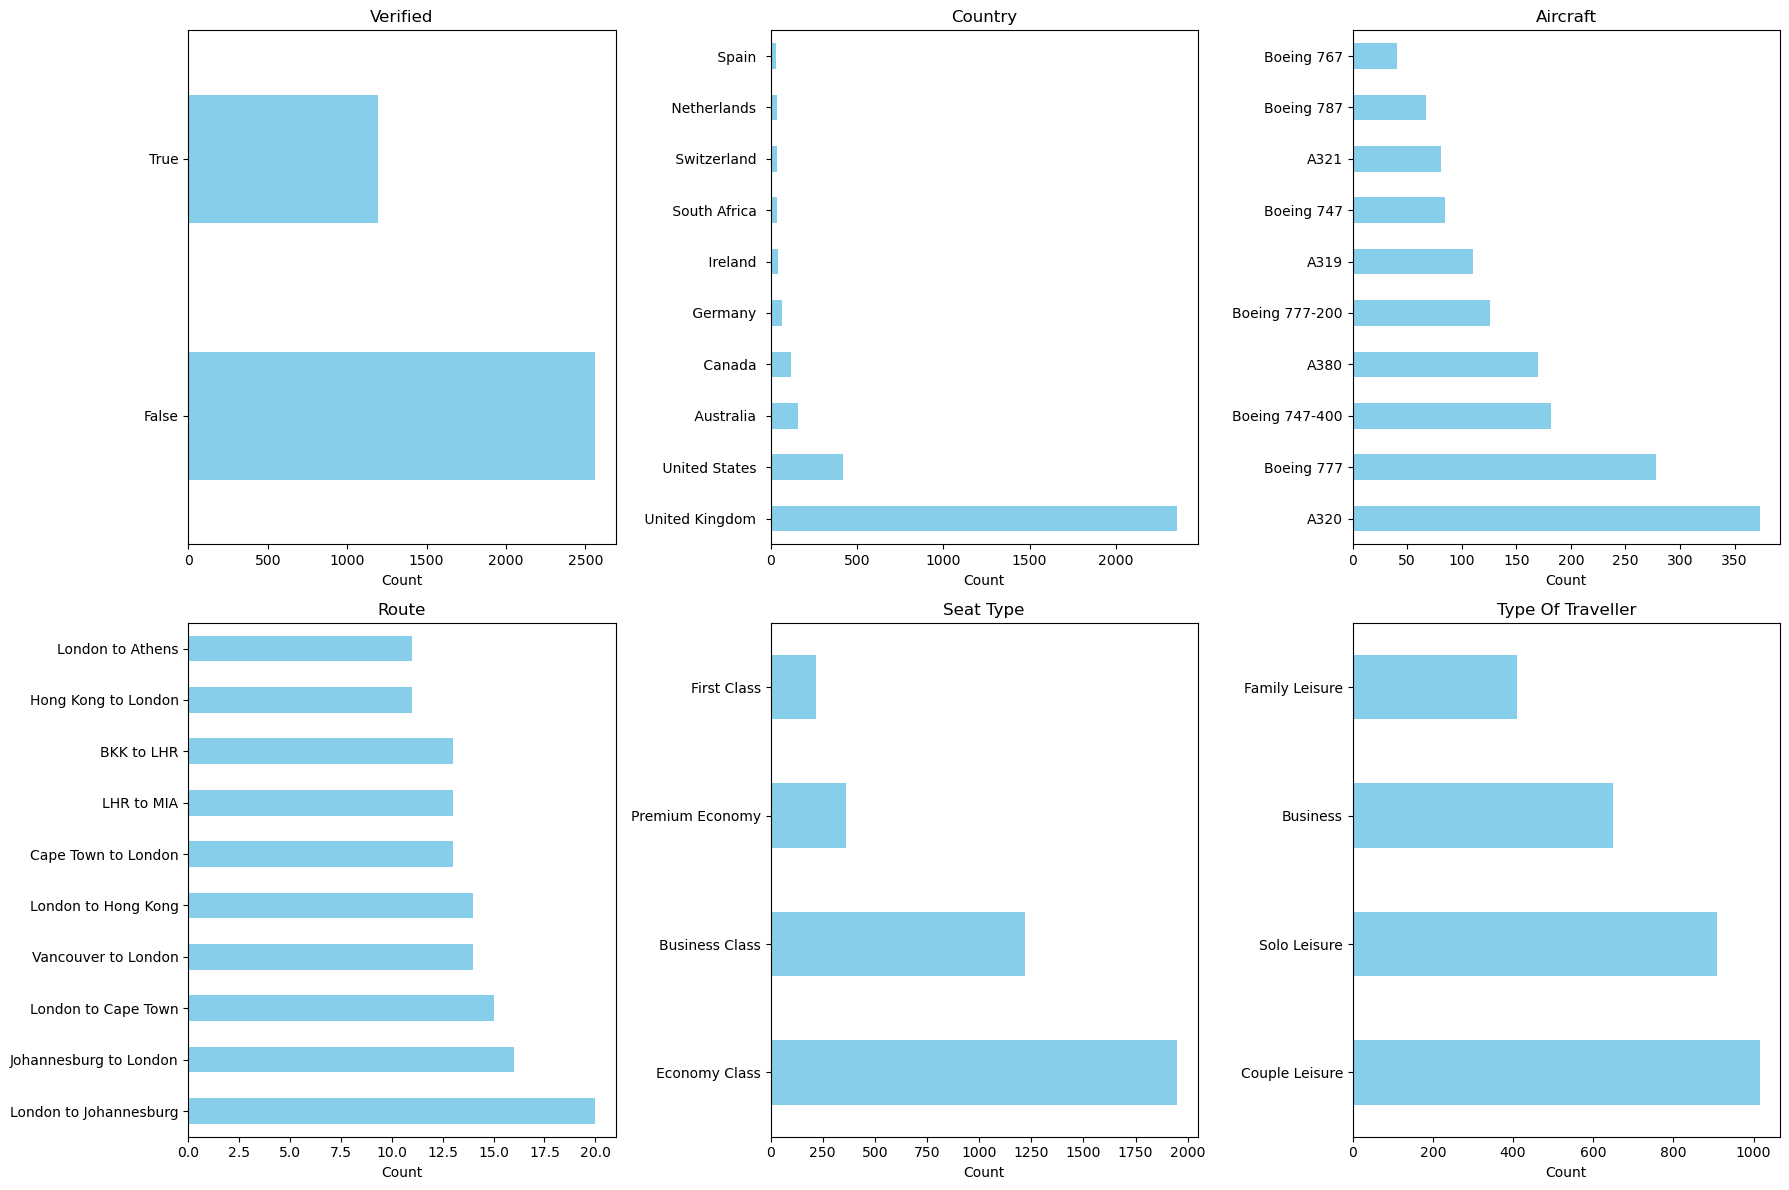

In [23]:
# List of columns to plot
columns_to_plot = ['Verified', 'Country', 'Aircraft', 'Route', 'Seat Type', 'Type Of Traveller']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjusted the subplot grid size

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate over each column and plot
for i, column in enumerate(columns_to_plot):
    # Exclude NaN values
    filtered_data = df[column].dropna()
    
    # Count occurrences of each value and select top 10
    top_10_counts = filtered_data.value_counts().head(10).sort_values(ascending=True)
    
    # Plot the data
    top_10_counts.plot(kind='barh', ax=axes[i], color='skyblue')
    
    # Add titles and labels
    axes[i].set_title(column)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
    axes[i].invert_yaxis()  # Invert y-axis to display highest count at the top

# Hide the remaining subplots if the number of columns to plot is less than the total number of subplots
for j in range(len(columns_to_plot), len(axes)):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Score Analysis

In [24]:
# Calculate the average score
df['Score'] = df[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity']].mean(axis=1)


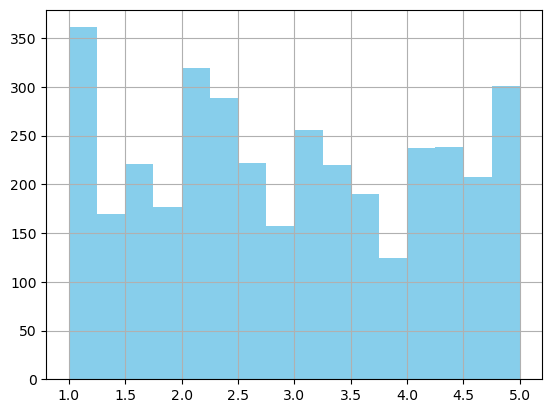

In [25]:
df['Score'].hist(bins = 16, color = 'skyblue')
plt.show()

In [26]:
score_summary = df['Score'].describe()

# Print the summary statistics
print("Summary Statistics for the 'Score' column:")
print(score_summary)

Summary Statistics for the 'Score' column:
count    3687.000000
mean        2.874324
std         1.220441
min         1.000000
25%         1.800000
50%         2.750000
75%         4.000000
max         5.000000
Name: Score, dtype: float64


In [27]:
df.set_index('Dates Review', inplace=True)
df.head()

,Day Review,Month Review,Month Review Number,Year Review,Verified,Review,Customer Name,Month Flown,Month Flown Number,Year Flown,...,Seat Type,Route,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Wifi & Connectivity,Recommended,Score
Dates Review,,,,,,,,,,,,,,,,,,,,,
2024-02-23,23,February,2,2024,True,That was supposed to be my flight but it was...,Peter Hansell,September,9,2023,...,Economy Class,Pisa to London Heathrow,NaN,NaN,NaN,NaN,1,NaN,0,NaN
2024-02-21,21,February,2,2024,True,Have no fear when your BA flight is operated...,Caleb Lowe,February,2,2024,...,Business Class,Malaga to London Heathrow,5.0,5.0,5.0,4.0,4,NaN,1,4.75
2024-02-17,17,February,2,2024,False,We have flown BA five times from western USA...,Kevin Statham,February,2,2024,...,Economy Class,Phoenix to Lisbon via London,1.0,5.0,3.0,1.0,1,1.0,0,2.20
2024-02-17,17,February,2,2024,True,London Heathrow to Istanbul at the start of ...,C Horton,February,2,2024,...,Economy Class,London to Istanbul,3.0,1.0,1.0,2.0,2,NaN,0,1.75
2024-02-16,16,February,2,2024,False,"Jan 30th, I booked a last-minute, transatlant...",Anthony C Gallagher,January,1,2024,...,Premium Economy,"Austin, TX to Shannon, Ireland via Austin",3.0,5.0,3.0,4.0,2,NaN,0,3.75


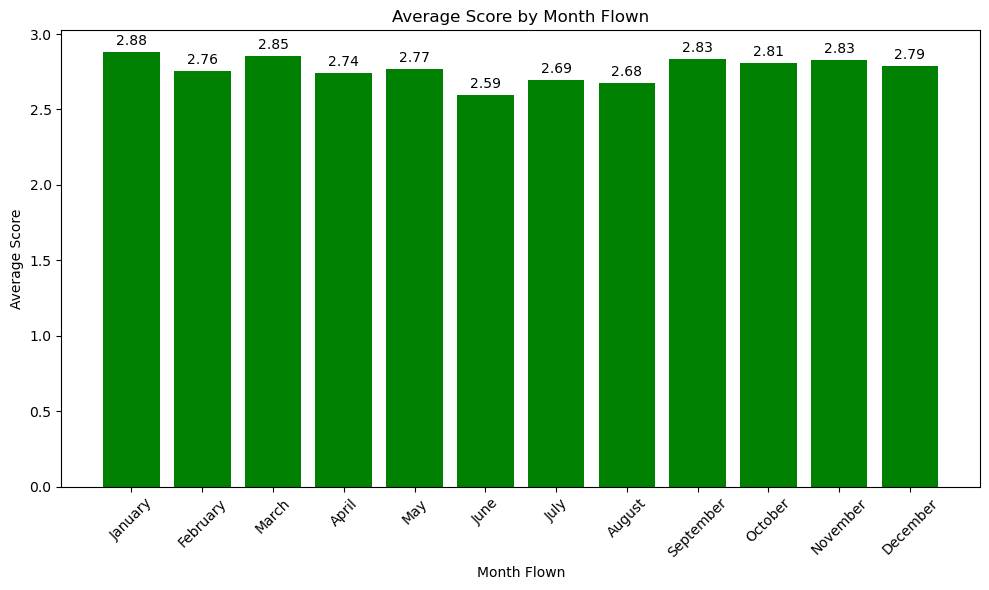

In [28]:
# Calculate the average score for each month
average_score_by_month = df.groupby('Month Flown Number')['Score'].mean()

# Sort the index to ensure the bar chart is ordered by month
average_score_by_month = average_score_by_month.sort_index()

# Get month names to use as labels
month_names = df.groupby('Month Flown Number')['Month Flown'].first()

# Plot the average score for each month using a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(month_names, average_score_by_month, color='green')
plt.xlabel('Month Flown')
plt.ylabel('Average Score')
plt.title('Average Score by Month Flown')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Add labels to the top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


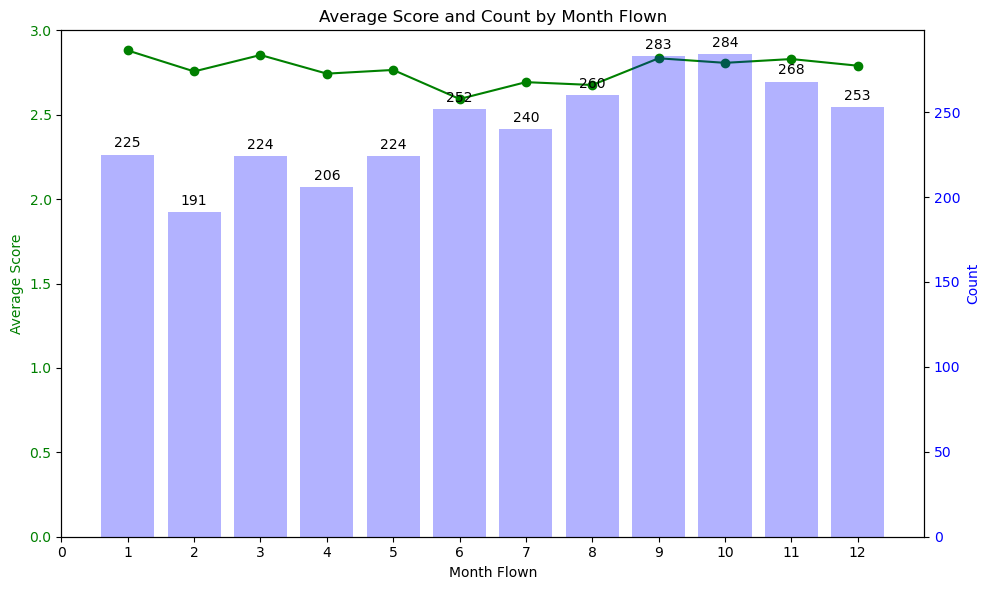

In [29]:
import matplotlib.pyplot as plt

# Filter out NaN values from the 'Month Flown' column and calculate the average score and count for each month
average_score_and_count_by_month = df.dropna(subset=['Month Flown']).groupby('Month Flown Number')['Score'].agg(['mean', 'count'])

# Sort the index to ensure the line plot is ordered by date
average_score_and_count_by_month = average_score_and_count_by_month.sort_index()

# Plot the average score for each date using a line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average score
color = 'green'
ax1.set_xlabel('Month Flown')
ax1.set_ylabel('Average Score', color=color)
ax1.plot(average_score_and_count_by_month.index, average_score_and_count_by_month['mean'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Set y-axis limit from 0 to 3
ax1.set_ylim(0, 3)

# Create a second y-axis for the count
ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('Count', color=color)
bars = ax2.bar(average_score_and_count_by_month.index, average_score_and_count_by_month['count'], color=color, alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)

# Add labels to the top of the bars
for bar in bars:
    height = bar.get_height()
    ax2.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Add title and rotate x-axis labels
plt.title('Average Score and Count by Month Flown')
plt.xticks(range(13))  # Set x-axis ticks from 0 to 12
plt.xlim(0, 13)  # Set x-axis limit to start from 0 and end at 12

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()


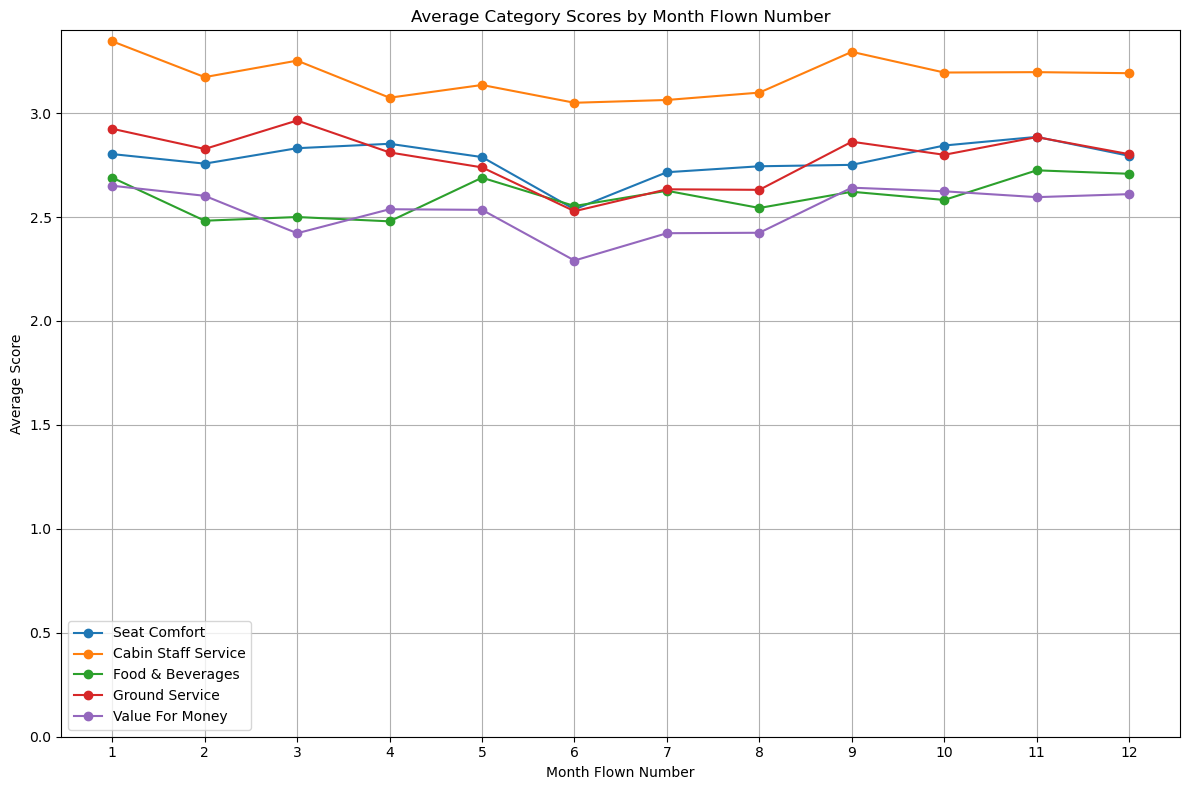

In [30]:
# Calculate the average score for each aspect by month flown
average_scores_by_month_number = df.groupby('Month Flown Number')[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']].mean()

# Plot the average scores for each aspect by month flown using a line plot
fig, ax = plt.subplots(figsize=(12, 8))

for column in average_scores_by_month_number.columns:
    average_scores_by_month_number[column].plot(kind='line', marker='o', label=column)

ax.set_xlabel('Month Flown Number')
ax.set_ylabel('Average Score')
ax.set_title('Average Category Scores by Month Flown Number')
ax.grid(True)  # Add gridlines to the plot

# Set x-axis ticks to range from 1 to 12
plt.xticks(range(1, 13))

plt.legend()  # Add legend to the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
ax.set_ylim(0)  # Set y-axis limit to start from 0
plt.show()

In [31]:
df.columns

Index(['Day Review', 'Month Review', 'Month Review Number', 'Year Review',
       'Verified', 'Review', 'Customer Name', 'Month Flown',
       'Month Flown Number', 'Year Flown', 'Month Year Flown', 'Country',
       'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
       'Value For Money', 'Wifi & Connectivity', 'Recommended', 'Score'],
      dtype='object')

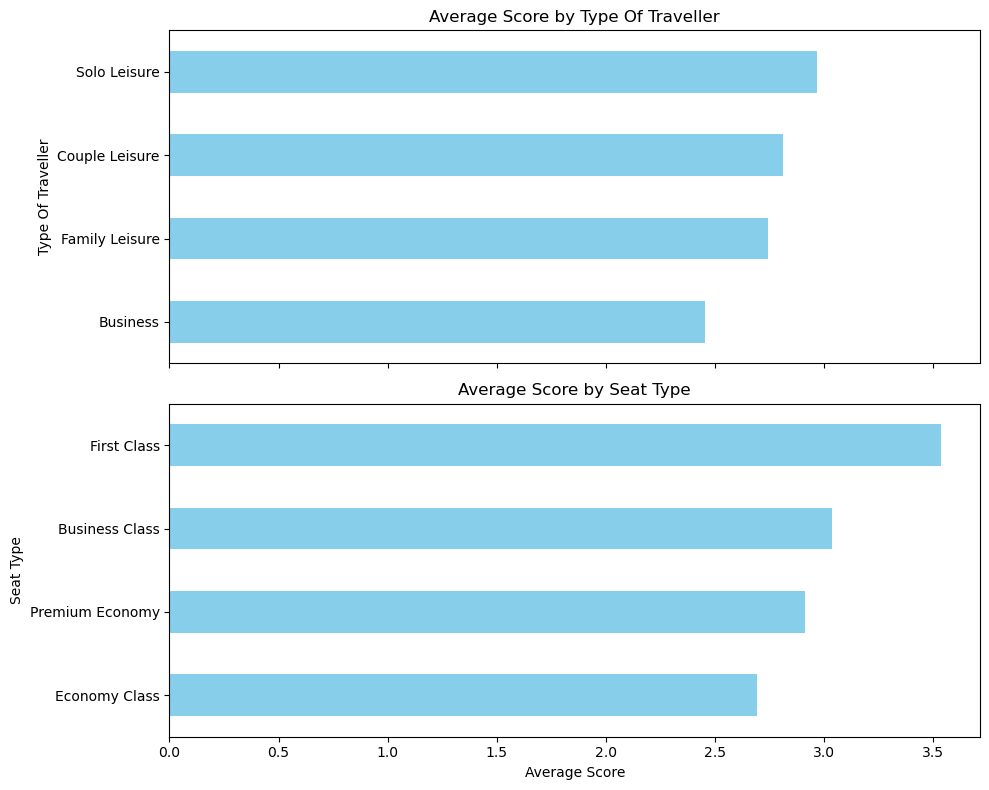

In [32]:
# List of columns to analyze
columns_to_analyze = ['Type Of Traveller', 'Seat Type']

# Create subplots
fig, axes = plt.subplots(nrows=len(columns_to_analyze), figsize=(10, 8), sharex=True)

# Iterate over each column and plot
for i, column in enumerate(columns_to_analyze):
    # Group by the column and calculate the mean score
    average_score_by_category = df.groupby(column)['Score'].mean().sort_values()
    
    # Plot the average score for each category
    average_score_by_category.plot(kind='barh', ax=axes[i], color='skyblue')
    
    # Set title and labels
    axes[i].set_title(f'Average Score by {column}')
    axes[i].set_ylabel(column)
    axes[i].set_xlabel('Average Score')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
def plot_scrollable_bar(df, column_name, title):
    # Calculate the average score for each category in the specified column
    average_score_by_category = df.groupby(column_name)['Score'].mean().sort_values()

    # Plot the average score for each category using a bar chart
    plt.figure(figsize=(20, 50))

    # Use subplot with adjustable box to enable scrolling
    plt.subplot(111, aspect='auto')
    plt.barh(average_score_by_category.index, average_score_by_category, color='skyblue')
    plt.xlabel('Average Score')
    plt.ylabel(column_name)
    plt.title(f'Average Score by {title}')
    plt.gca().invert_yaxis()  # Invert y-axis to display highest average score at the top
    plt.tight_layout()

    # Enable interactive scrolling
    plt.subplots_adjust(left=0.25, right=0.9, top=0.9, bottom=0.1)
    plt.show()

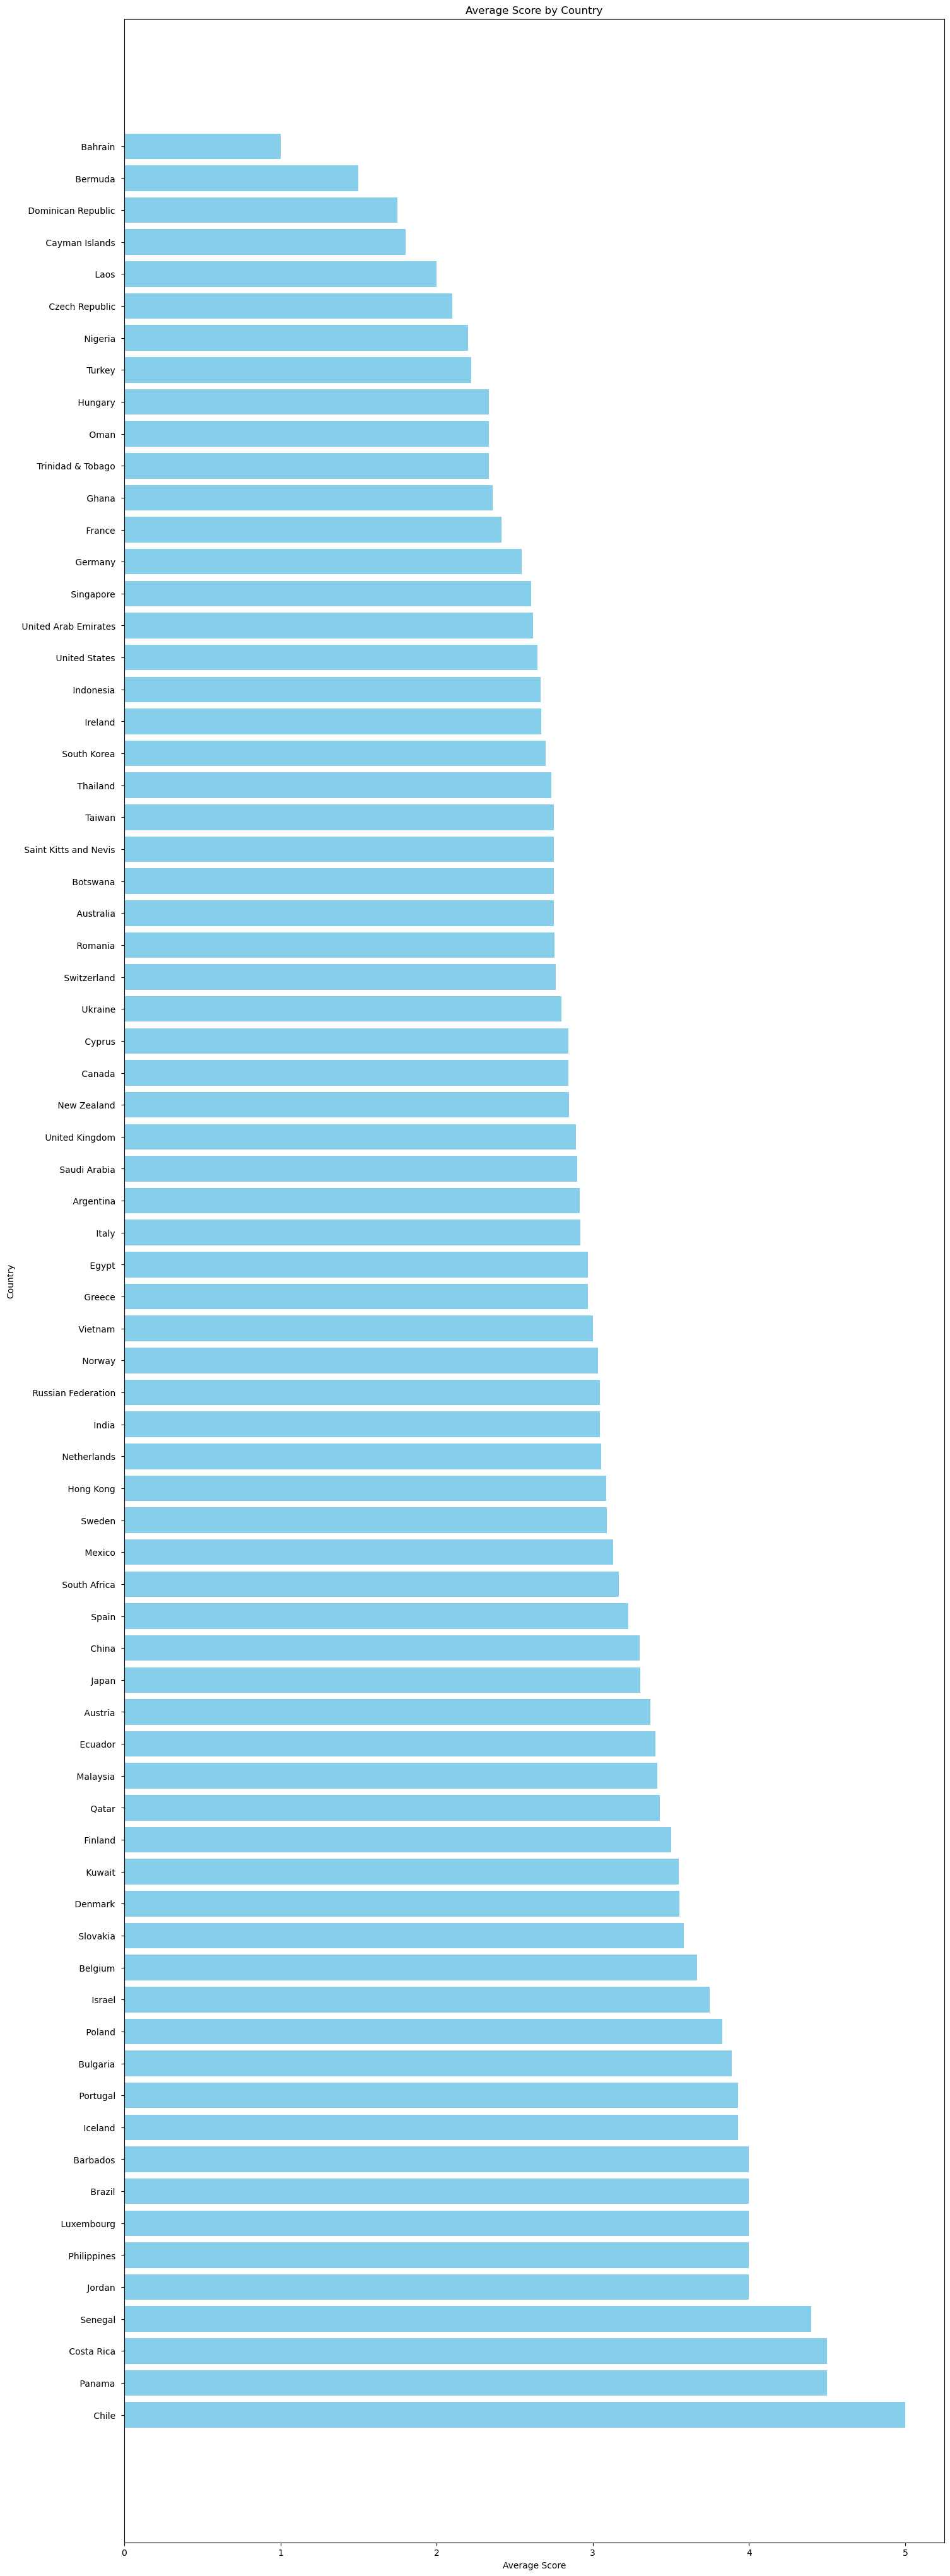

In [34]:
# Plot for 'Country'
plot_scrollable_bar(df, 'Country', 'Country')

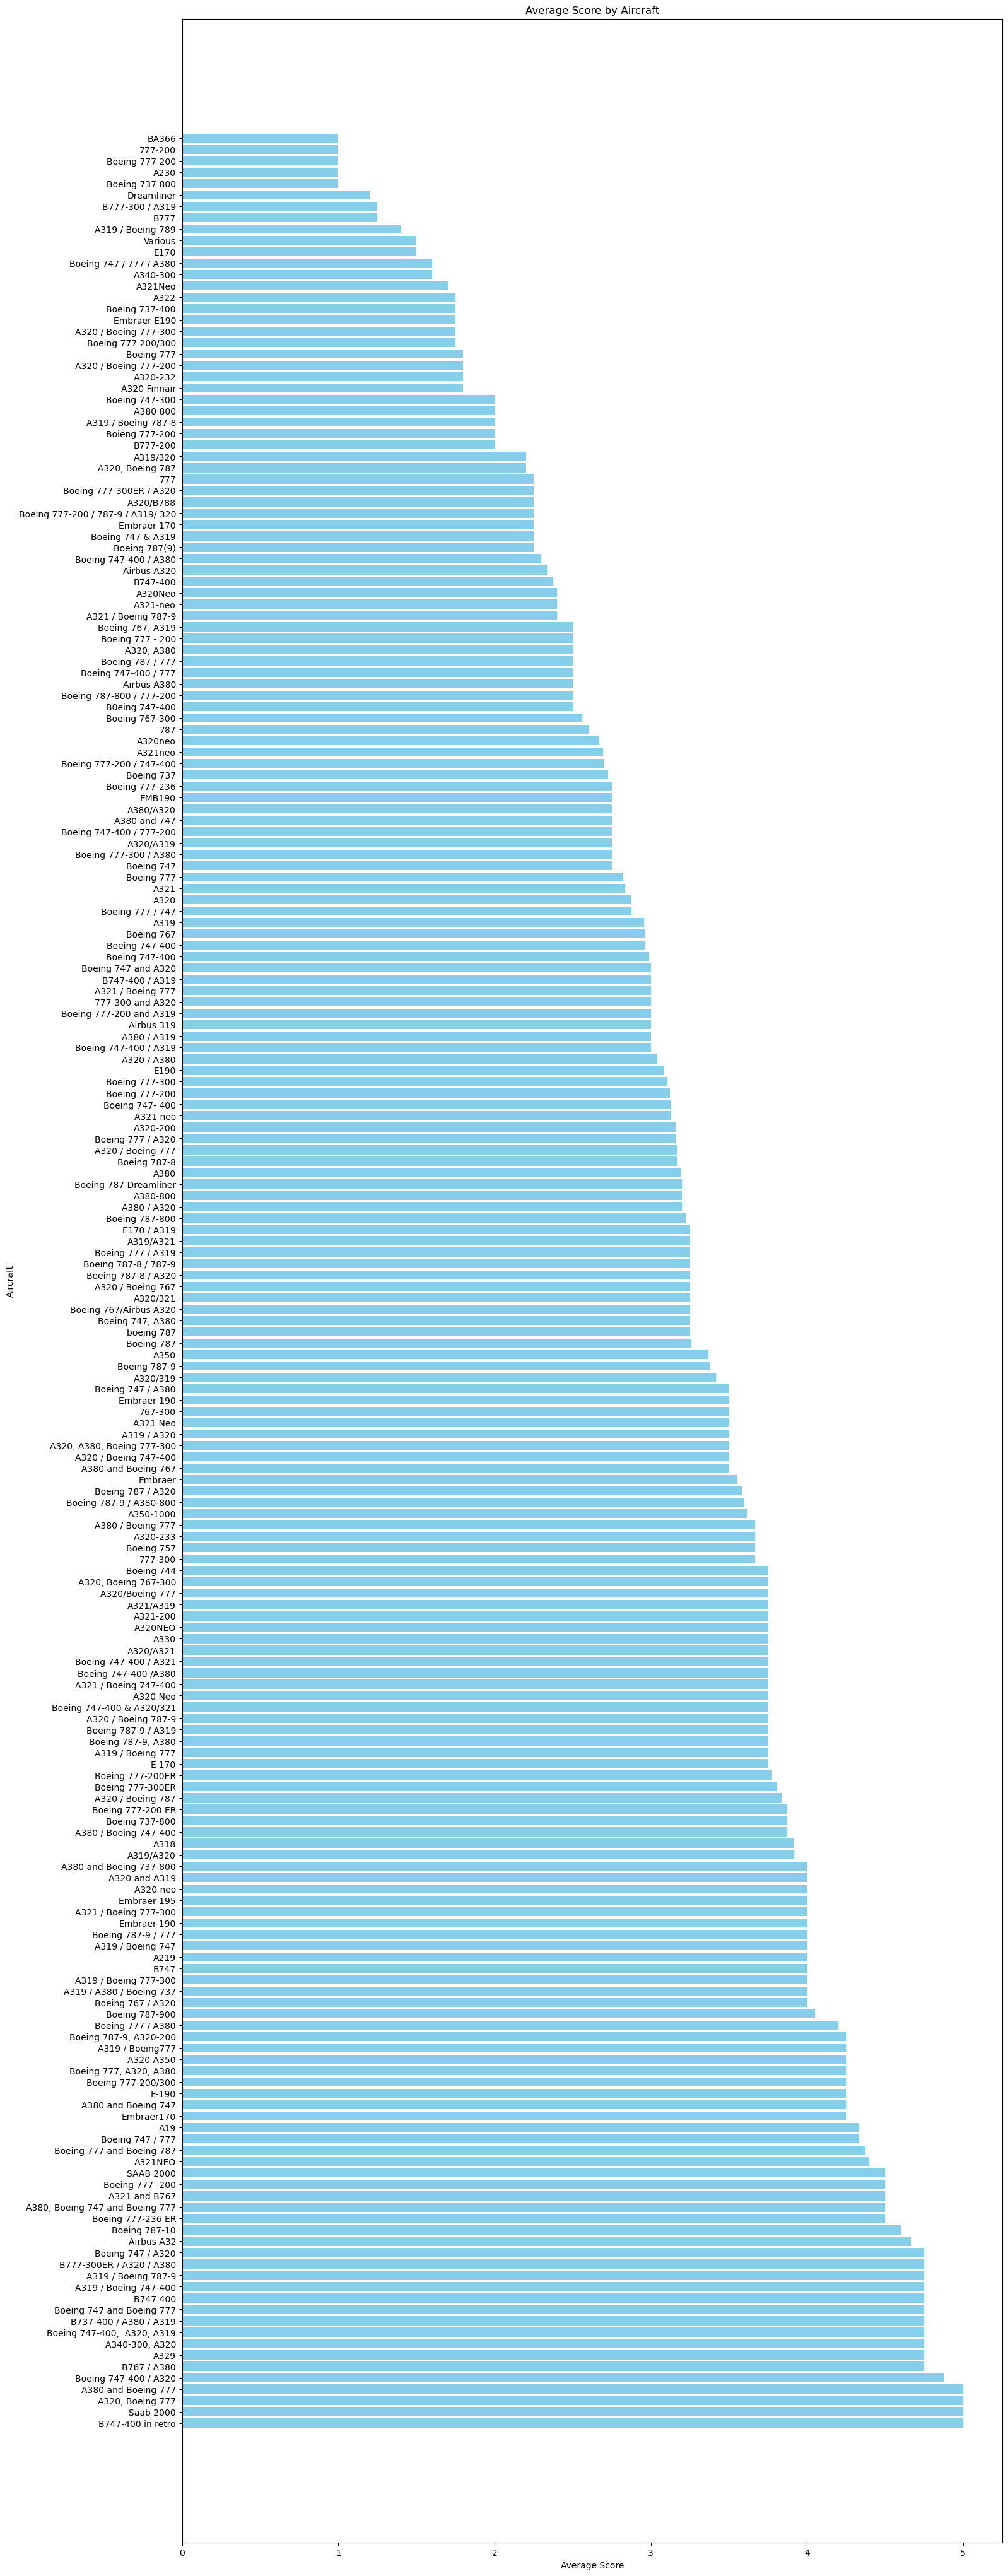

In [35]:
# Plot for 'Route'
plot_scrollable_bar(df, 'Aircraft', 'Aircraft')

In [36]:
df.columns

Index(['Day Review', 'Month Review', 'Month Review Number', 'Year Review',
       'Verified', 'Review', 'Customer Name', 'Month Flown',
       'Month Flown Number', 'Year Flown', 'Month Year Flown', 'Country',
       'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
       'Value For Money', 'Wifi & Connectivity', 'Recommended', 'Score'],
      dtype='object')

## Time Series

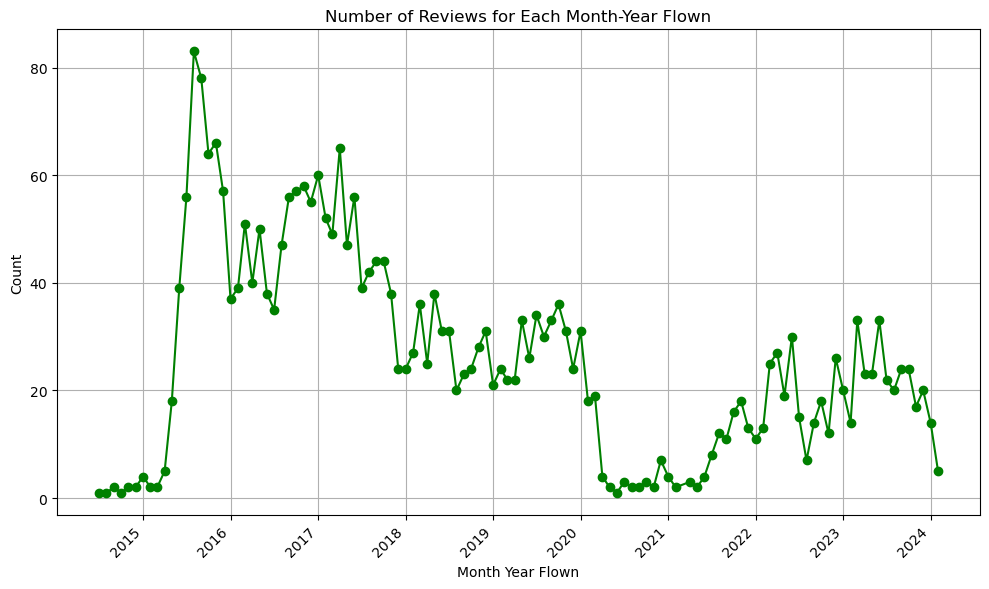

In [37]:
# Convert 'Month Year Flown' to datetime
df['Month Year Flown'] = pd.to_datetime(df['Month Year Flown'], format='%m/%Y')

# Count the occurrences of each month-year combination
month_year_flown_counts = df['Month Year Flown'].value_counts()

# Sort the index to ensure the line plot is ordered by month-year
month_year_flown_counts = month_year_flown_counts.sort_index()

# Plot the count of occurrences for each month-year combination using a line plot
month_year_flown_counts.plot(kind='line', figsize=(10, 6), marker='o', color='green', linestyle='-')
plt.xlabel('Month Year Flown')
plt.ylabel('Count')
plt.title('Number of Reviews for Each Month-Year Flown')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Add gridlines to the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

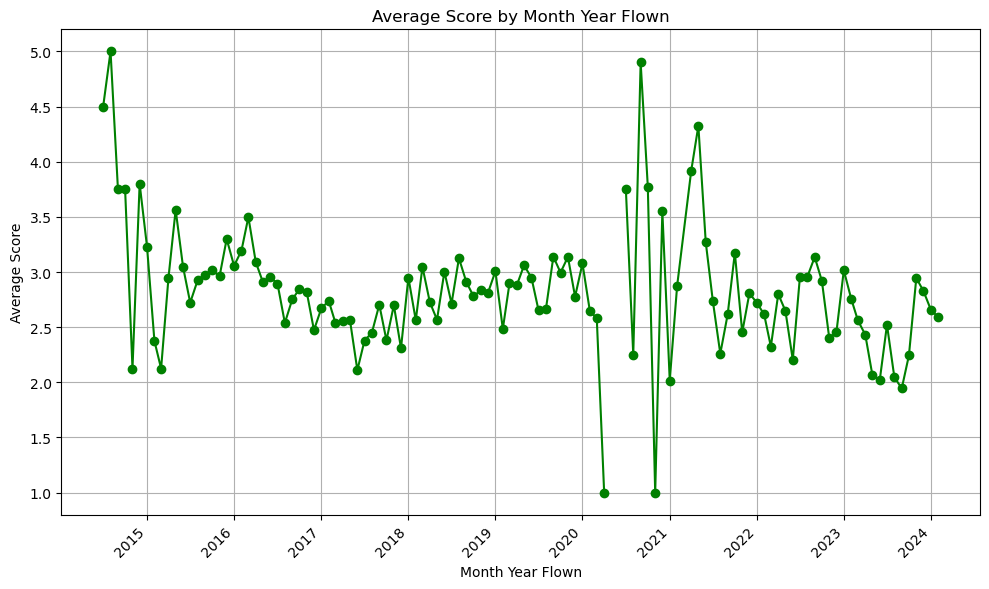

In [38]:
# Calculate the average score for each 'Month Year Flown'
average_score_by_month_year = df.groupby('Month Year Flown')['Score'].mean()

# Sort the index to ensure the line plot is ordered by 'Month Year Flown'
average_score_by_month_year = average_score_by_month_year.sort_index()

# Plot the average score for each 'Month Year Flown' using a line plot
average_score_by_month_year.plot(kind='line', figsize=(10, 6), marker='o', color='green', linestyle='-')
plt.xlabel('Month Year Flown')
plt.ylabel('Average Score')
plt.title('Average Score by Month Year Flown')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Add gridlines to the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [39]:
import matplotlib.dates as mdates

# Filter out NaN values from the 'Month Flown' column and calculate the average score for each date
average_score_by_date = df.dropna(subset=['Month Year Flown']).groupby('Month Year Flown')['Score'].mean()

# Sort the index to ensure the line plot is ordered by date
average_score_by_date = average_score_by_date.sort_index()

# Filter out averages greater than or equal to 4
average_score_by_date_filtered = average_score_by_date[average_score_by_date >= 4]

average_score_by_date_filtered.sort_values(ascending = False)

Month Year Flown
2014-08-01    5.000
2020-09-01    4.900
2014-07-01    4.500
2021-05-01    4.325
Name: Score, dtype: float64

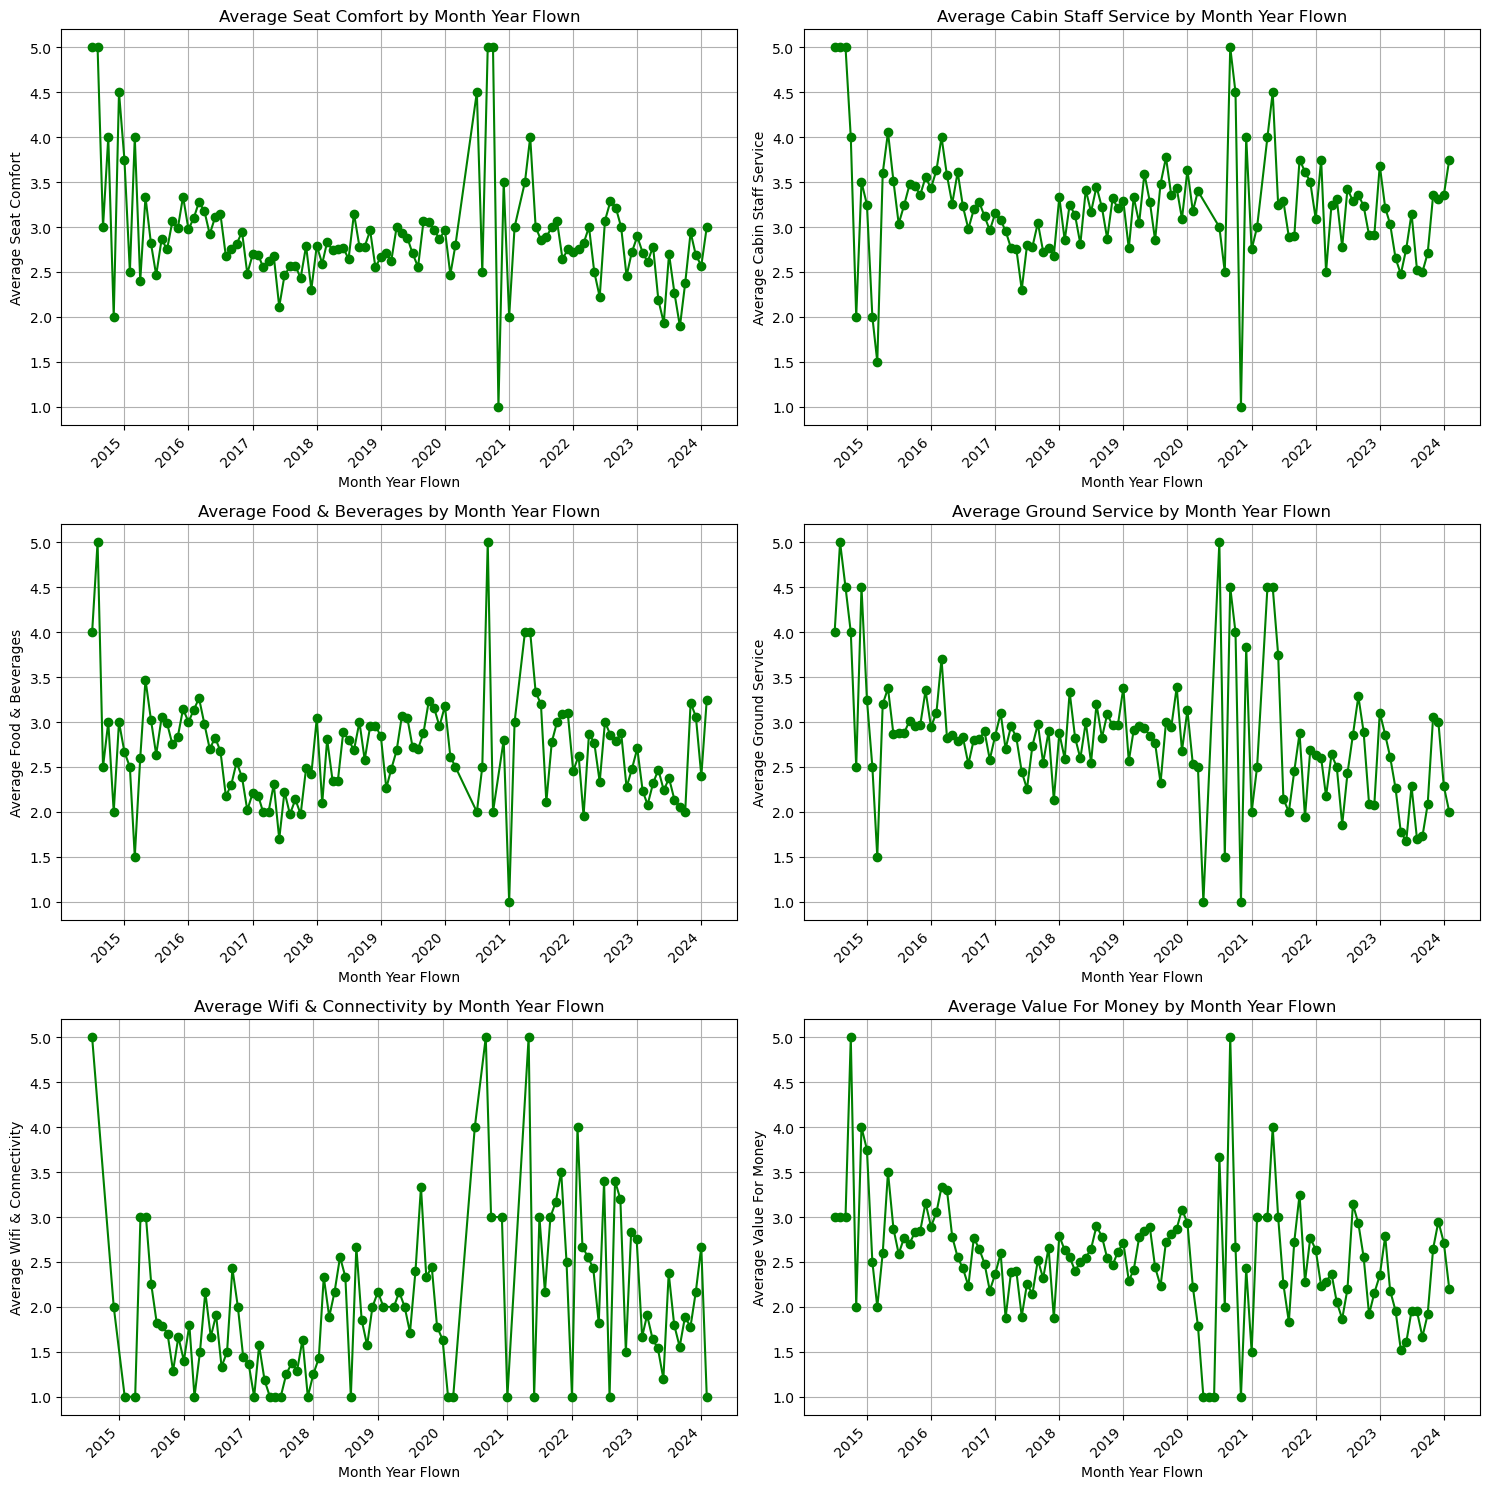

In [40]:
# Define the list of columns
columns_to_plot = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Iterate over each column and plot the average score by date flown
for i, column in enumerate(columns_to_plot):
    # Filter out NaN values in the specified column and group by 'Date Flown' to calculate the average
    filtered_data = df.dropna(subset=['Month Year Flown', column])
    average_by_date = filtered_data.groupby('Month Year Flown')[column].mean()
    average_by_date = average_by_date.sort_index()

    # Plot the average score for each date using a line plot
    average_by_date.plot(kind='line', ax=axes[i], marker='o', color='green', linestyle='-')
    axes[i].set_xlabel('Month Year Flown')
    axes[i].set_ylabel('Average ' + column)
    axes[i].set_title('Average ' + column + ' by Month Year Flown')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
    axes[i].grid(True)  # Add gridlines to the plot

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


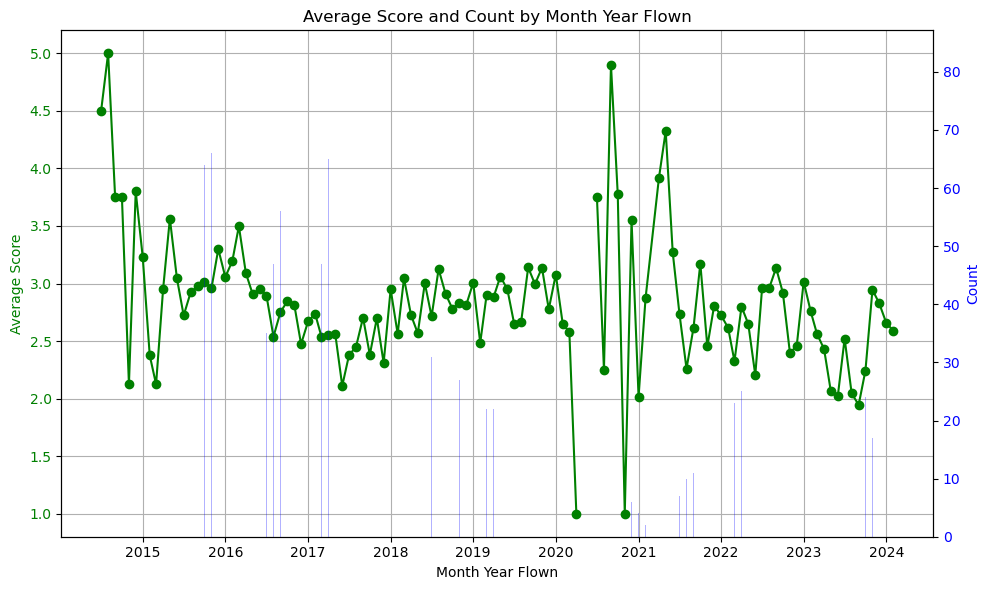

In [41]:
# Calculate the average score and count for each 'Month Year Flown'
average_score_and_count_by_month_year = df.groupby('Month Year Flown')['Score'].agg(['mean', 'count'])

# Sort the index to ensure the line plot is ordered by date
average_score_and_count_by_month_year = average_score_and_count_by_month_year.sort_index()

# Plot the average score for each date using a line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average score
color = 'green'
ax1.set_xlabel('Month Year Flown')
ax1.set_ylabel('Average Score', color=color)
ax1.plot(average_score_and_count_by_month_year.index, average_score_and_count_by_month_year['mean'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the count
ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('Count', color=color)
ax2.bar(average_score_and_count_by_month_year.index, average_score_and_count_by_month_year['count'], color=color, alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and rotate x-axis labels
plt.title('Average Score and Count by Month Year Flown')
plt.xticks(rotation=45)

# Add gridlines to the plot
ax1.grid(True)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()


## Review Sentiment Analysis

In [42]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\m.pham\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

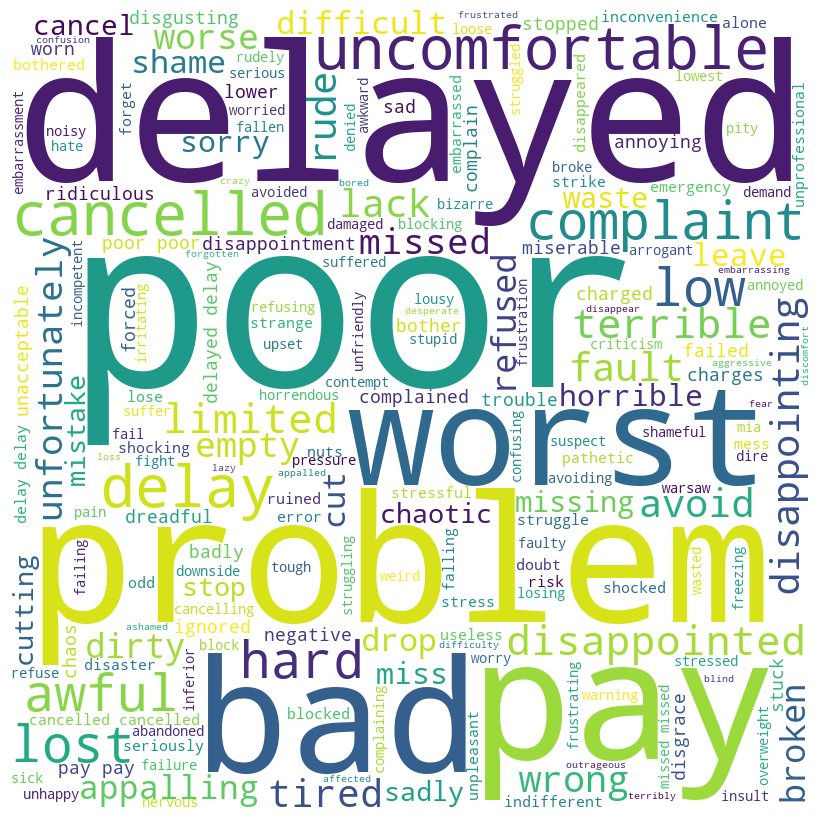

In [43]:
# Combine all reviews into a single string
reviews_text = ' '.join(df['Review'].dropna())

# Tokenize the text
tokens = word_tokenize(reviews_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

# Perform sentiment analysis to identify negative words
sid = SentimentIntensityAnalyzer()
negative_words = [word for word in filtered_tokens if sid.polarity_scores(word)['compound'] < 0]

# Combine negative words into a single string
negative_text = ' '.join(negative_words)

# Create and generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(negative_text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()

          Word  Frequency
60        poor        648
55     delayed        520
43         pay        478
6        delay        362
0    cancelled        340
..         ...        ...
644    starved          1
643       glum          1
641   stalling          1
639   strained          1
950    grimace          1

[951 rows x 2 columns]


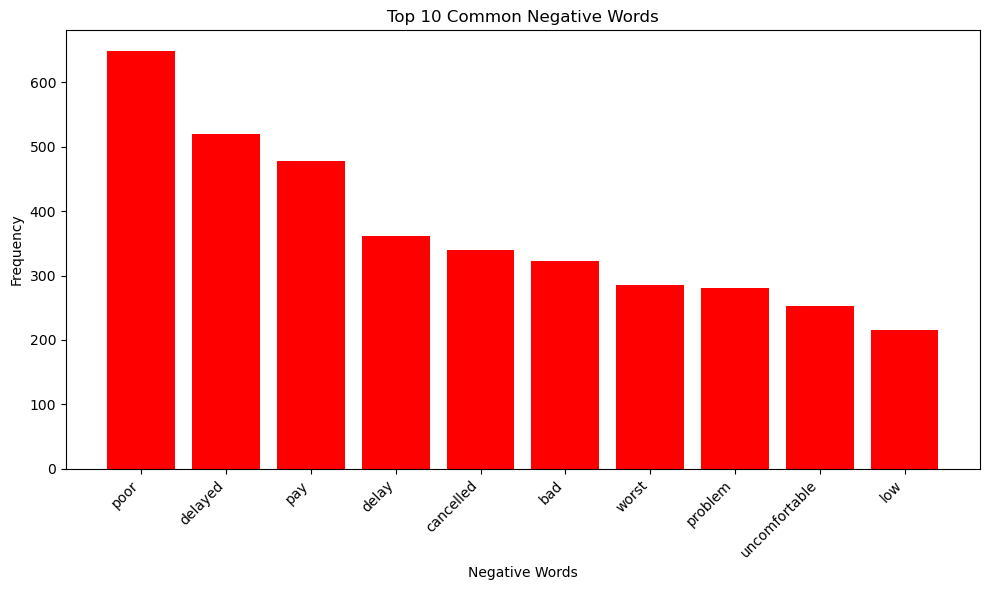

In [44]:
# Count occurrences of each negative word
word_freq = {}
for word in negative_words:
    word_freq[word] = word_freq.get(word, 0) + 1

# Create a DataFrame from the word frequency dictionary
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Print the list of common negative words and their occurrences
print(word_freq_df)

# Plot the occurrences using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(word_freq_df['Word'][:10], word_freq_df['Frequency'][:10], color='red')
plt.xlabel('Negative Words')
plt.ylabel('Frequency')
plt.title('Top 10 Common Negative Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
# Function to check if the review contains the word "delay" or "delayed"
def check_delay(review):
    if 'delay' in review.lower() or 'delayed' in review.lower():
        return 1
    else:
        return 0

# Apply the function to create the 'Delay' column
df['Delay'] = df['Review'].apply(check_delay)

In [46]:
df.head()

,Day Review,Month Review,Month Review Number,Year Review,Verified,Review,Customer Name,Month Flown,Month Flown Number,Year Flown,...,Route,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Wifi & Connectivity,Recommended,Score,Delay
Dates Review,,,,,,,,,,,,,,,,,,,,,
2024-02-23,23,February,2,2024,True,That was supposed to be my flight but it was...,Peter Hansell,September,9,2023,...,Pisa to London Heathrow,NaN,NaN,NaN,NaN,1,NaN,0,NaN,0
2024-02-21,21,February,2,2024,True,Have no fear when your BA flight is operated...,Caleb Lowe,February,2,2024,...,Malaga to London Heathrow,5.0,5.0,5.0,4.0,4,NaN,1,4.75,1
2024-02-17,17,February,2,2024,False,We have flown BA five times from western USA...,Kevin Statham,February,2,2024,...,Phoenix to Lisbon via London,1.0,5.0,3.0,1.0,1,1.0,0,2.20,0
2024-02-17,17,February,2,2024,True,London Heathrow to Istanbul at the start of ...,C Horton,February,2,2024,...,London to Istanbul,3.0,1.0,1.0,2.0,2,NaN,0,1.75,0
2024-02-16,16,February,2,2024,False,"Jan 30th, I booked a last-minute, transatlant...",Anthony C Gallagher,January,1,2024,...,"Austin, TX to Shannon, Ireland via Austin",3.0,5.0,3.0,4.0,2,NaN,0,3.75,0


In [47]:
# Calculate the percentage of flights that have been delayed and round to two decimal places
percentage_delayed = round((df['Delay'].mean()) * 100, 2)

print("Percentage of flights that have been delayed:", percentage_delayed, "%")

Percentage of flights that have been delayed: 18.06 %


In [49]:
# Function to check if the review contains the word "cancel"
def check_cancel(review):
    if 'cancel' in review.lower():
        return 1
    else:
        return 0

# Apply the function to create the 'Cancel' column
df['Cancel'] = df['Review'].apply(check_cancel)


In [50]:
# Calculate the percentage of flights that have been canceled and round to two decimal places
percentage_canceled = round((df['Cancel'].mean()) * 100, 2)

print("Percentage of flights that have been canceled:", percentage_canceled, "%")


Percentage of flights that have been canceled: 9.0 %
